## CSE 574 Planing and Learning Methods in AI (Fall 2023)

# Assignment 1: Part 2

## Multi-Objective Bayesian Optimization

### 1. Getting to know software libraries

In [ ]:
# Install BoTorch
!pip install botorch

In [ ]:
# Import functions that you might need to use
import numpy as np
import matplotlib.pyplot as plt
import torch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf
from botorch.utils.transforms import unnormalize, normalize
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from botorch.sampling.normal import SobolQMCNormalSampler
import warnings
warnings.filterwarnings("ignore")

In this assignment, we minimize two objective functions using Bayesian Optimization.

The first objective function $f_1$ is the neural network with weights loaded from "net_f1.pth".

The second objective function $f_2$ is the neural network with weights loaded from "net_f2.pth".

You should perform the optimization with respect to $x$ within the range of $[-1,1]$.

In [ ]:
# Declare the bound and define the functions of f1 and f2. You can use f1 and f2 defined below.
import torch.nn as nn
class Approximator(nn.Module):
    def __init__(self):
        super(Approximator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

net_f1 = Approximator()
net_f2 = Approximator()
net_f1 = torch.load('/net_f1.pth', map_location=torch.device('cpu'))#Added the file to root directory
net_f2 = torch.load('/net_f2.pth', map_location=torch.device('cpu'))#Added the file to root directory

def f1(x):
    y = net_f1(torch.FloatTensor(x)).item()
    return y

def f2(x):
    y = net_f2(torch.FloatTensor(x)).item()
    return y


### 2. Examining the black box functions

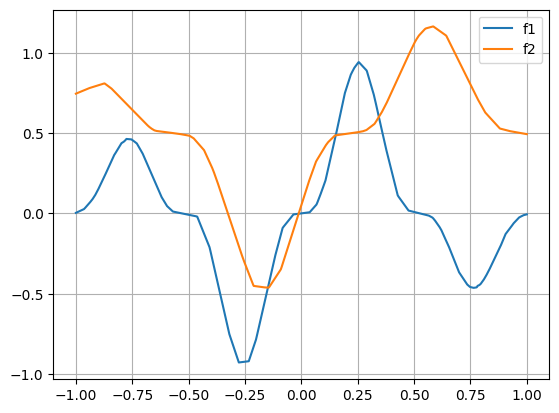

In [ ]:
# Plot f1 and f2 in the same figure.
# Below is what the figure will look like.

bounds = torch.tensor([-1, 1])
xs = np.linspace(bounds[0], bounds[1], 1000)
xs = xs.reshape((1000, -1))
# COMPLETE
y1=[]
y2=[]
# Append y1 and y2 to the lists for displaying it on the plot
for input  in xs:
  y1.append(f1(input))
  y2.append(f2(input))
plt.plot(xs,y1,label='f1')
plt.plot(xs,y2,label='f2')
plt.legend()
plt.grid()
plt.show()

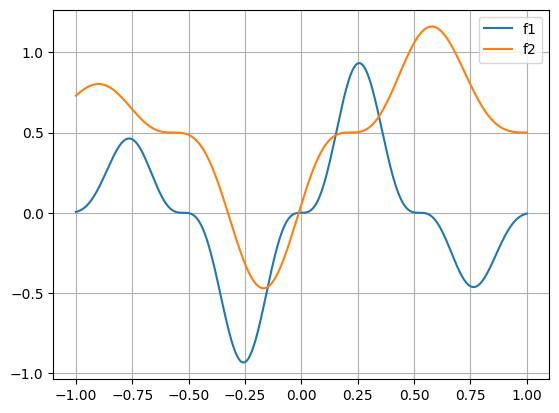

### 3. Setting up the Gaussian process and acquisition function

In [ ]:
# Define a function as the main Bayesian Optimization loop of the multi-objective Bayesian Optimization.
# The input of the function: All x along with their observatioons from two objective functions.
# The output of the function: The next candidate x.

# generate_next_candidate(x, y):
#    Step 1. Define the Gaussian Process model for each objective, and maximize their Marginal Log Likelihood.
#    Step 2. Construct the multi-objective acquisition function (You can use qExpectedHypervolumeImprovement here.)
#    Step 3. Optimize the acquisition to find the next candidate x.
# return candidate

def initialize_model(train_x, train_y):

    train_x = normalize(train_x, bounds)
    models = []

    for i in range(train_y.shape[-1]):
        train_objective = train_y[:, i]
        x_gp = train_x #COMPLETE
        y_gp = train_objective  #COMPLETE
        models.append(
            SingleTaskGP(x_gp, y_gp.unsqueeze(-1))
        )
    model = ModelListGP(*models)
    return model

def generate_next_candidate(x, y):
    # Define and initialize the GP model
    model = initialize_model(x, y)
    mll = SumMarginalLogLikelihood( model.likelihood,model ) # COMPLETE - Pass the correct arguments into this function

    fit_gpytorch_model(mll) # COMPLETE - Pass the correct argument/s into this function

    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))

    train_x = normalize(x, bounds)

    partitioning = NondominatedPartitioning(ref_point=torch.FloatTensor([-1, -1]), Y=y)
    acq_fun = qExpectedHypervolumeImprovement(
        model = model,#COMPLETE
        ref_point =torch.FloatTensor([-1,1]),#COMPLETE
        partitioning = partitioning,#COMPLETE
        sampler = sampler#COMPLETE
    )

    candidates, _ = optimize_acqf(
        acq_function = acq_fun, #COMPLETE,
        bounds = torch.tensor([[0.0], [1.0]]),#COMPLETE Bounds are 0-1 because it is normalized
        q=1,
        num_restarts=20,
        raw_samples=1024,
    )
    candidates = unnormalize(candidates, bounds)
    return candidates

### 4. Running Bayesian optimization

In [ ]:
# Run the Multi-objective Bayesian Optimization
# Step 1. Generate initial x with their observations of the two objectives.
#         You can start with three x randomly generated within [-1,1].
# Step 2. Iteratively run the Multi-objective Bayesian Optimization on current training data to find new candidate,
#         and add the new candidate to your training data.
# Step 3. Please plot all the candiates and their observations of the two objectives at each iteration.

# Hint: Note that we aim to minimize the objective functions instead of maximize.

# Below are what all the figures look like.
# After 15 iterations an optimal has been reached around x = -0.2, which is in fact a zone where both functions reach minimum.

### 5. Examining the Pareto front

In [ ]:
def plot_candidates(candidates):
    # COMPLETE
    xs = np.linspace(bounds[0], bounds[1], 1000)
    xs = xs.reshape((1000, -1))
    y1=[]
    y2=[]
    for input  in xs:
      y1.append(f1(input))
      y2.append(f2(input))
    plt.plot(xs,y1,label='f1')
    plt.plot(xs,y2,label='f2')
    plt.scatter(candidates[:, 0], candidates[:, 1], c='blue', label='Candidates')
    plt.scatter(candidates[:, 0], candidates[:, 2], c='orange', label='Candidates')

    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def generate_initial_data(n_samples):
    x_init = torch.tensor(bounds[0]) + torch.rand(n_samples, 1) * (torch.tensor(bounds[1]) - torch.tensor(bounds[0]))
    y=[]
    for input in x_init:
      y.append([f1([input[0].item()]),f2([input[0].item()])])
    y_init = torch.tensor(y)# COMPLETE
    return x_init, y_init

tensor([[ 0.1757],
        [ 0.3353],
        [-0.8324]]) tensor([[0.6355, 0.4909],
        [0.6546, 0.5815],
        [0.3566, 0.7638]])


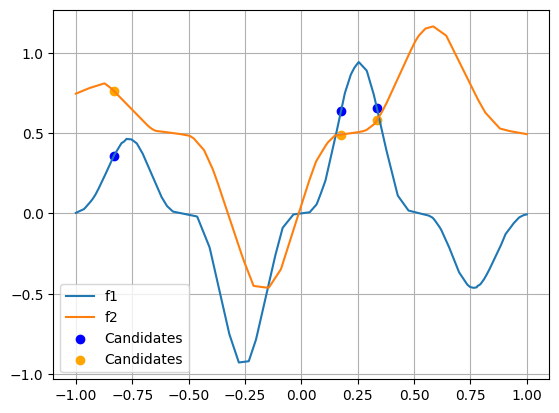

Iteration 0
Candidate: tensor([[-0.2866]])


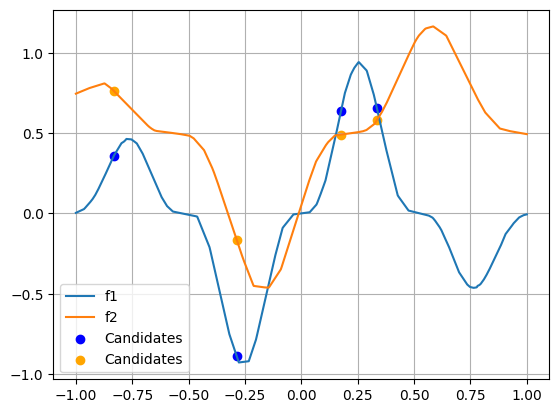

Iteration 1
Candidate: tensor([[-0.3838]])


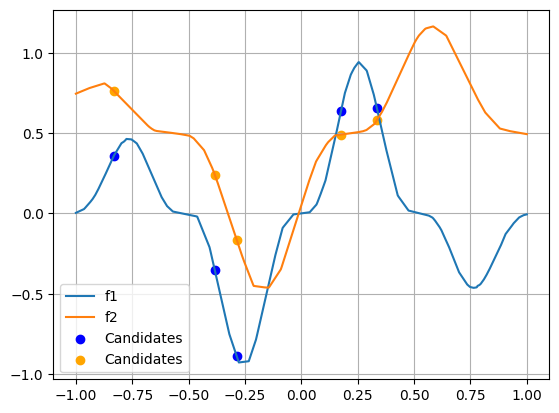

Iteration 2
Candidate: tensor([[1.]])


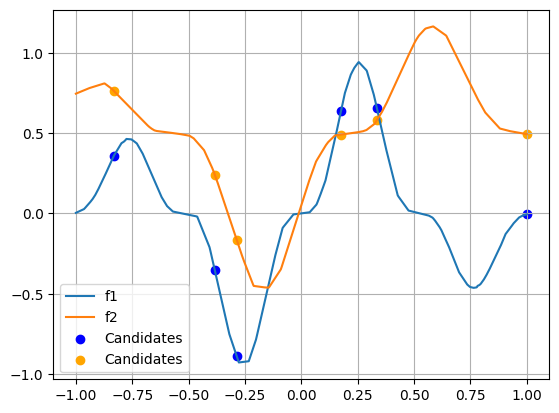

Iteration 3
Candidate: tensor([[-0.1867]])


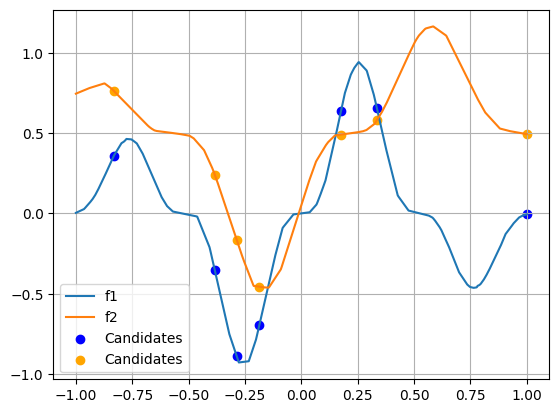

Iteration 4
Candidate: tensor([[-0.1454]])


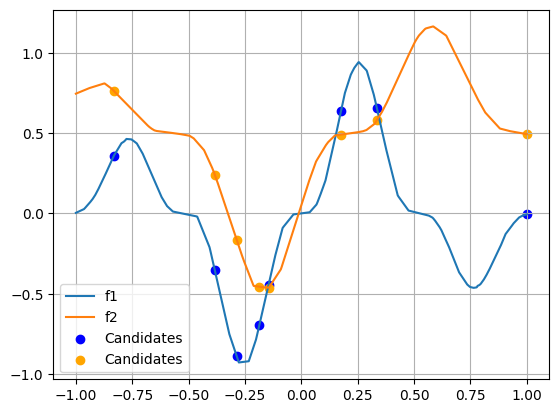

Iteration 5
Candidate: tensor([[0.7266]])


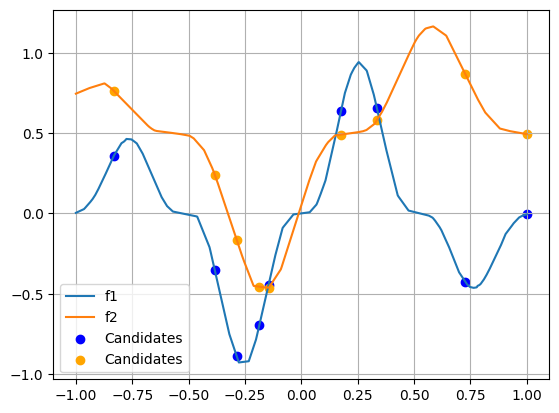

Iteration 6
Candidate: tensor([[-0.2504]])


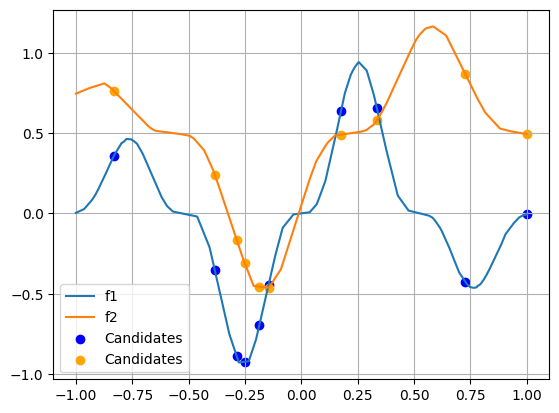

Iteration 7
Candidate: tensor([[-0.2178]])


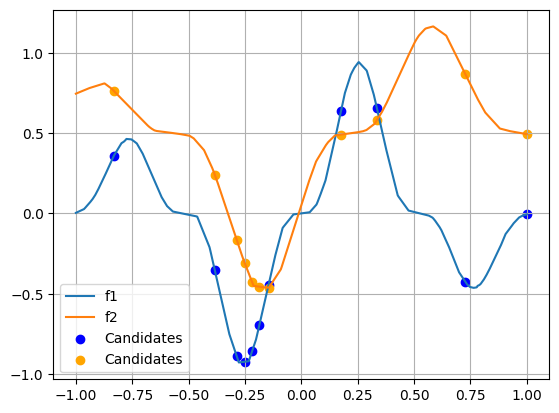

Iteration 8
Candidate: tensor([[-0.1691]])


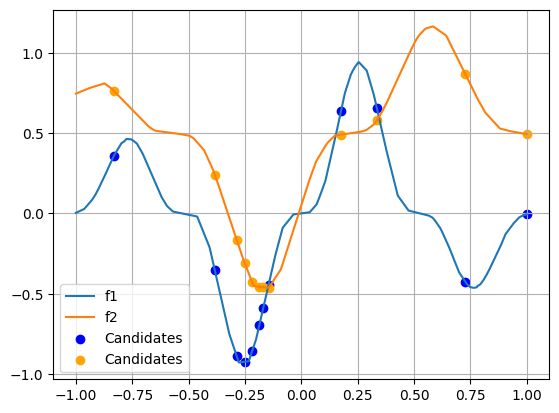

Iteration 9
Candidate: tensor([[-0.1692]])


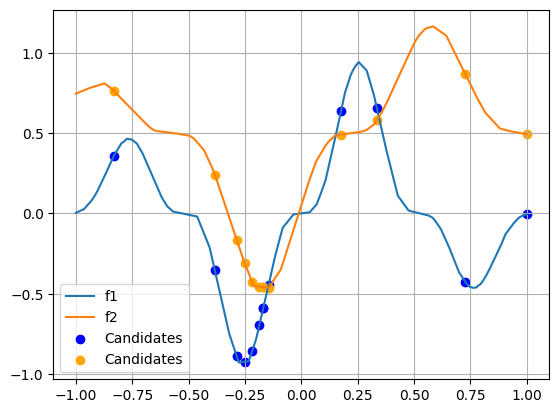

Iteration 10
Candidate: tensor([[-0.1597]])


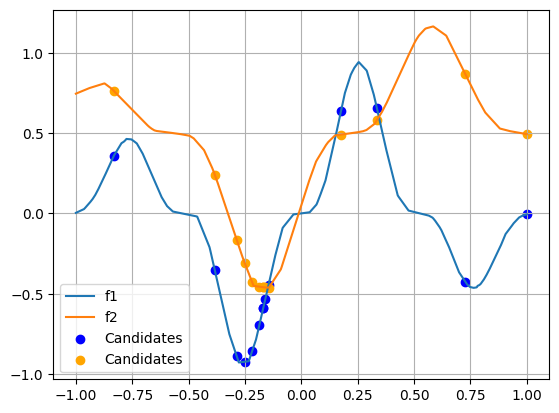

Iteration 11
Candidate: tensor([[-0.2575]])


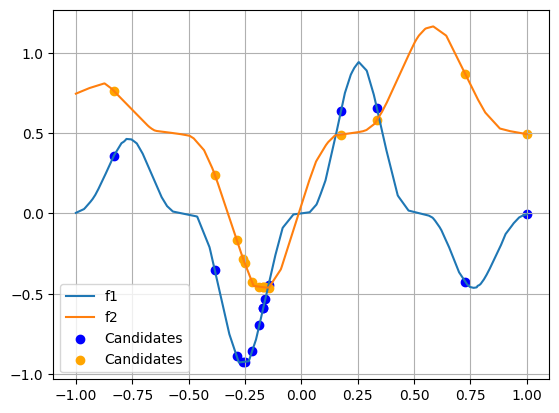

Iteration 12
Candidate: tensor([[-0.1584]])


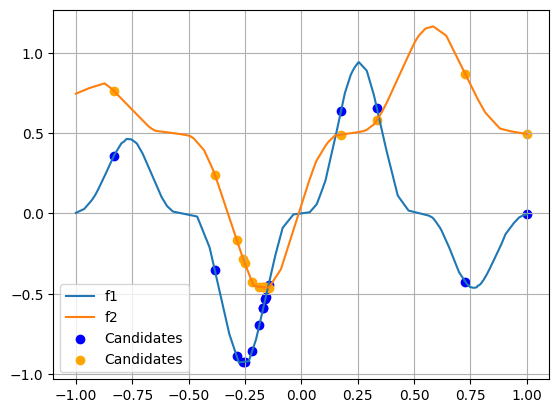

Iteration 13
Candidate: tensor([[-0.1707]])


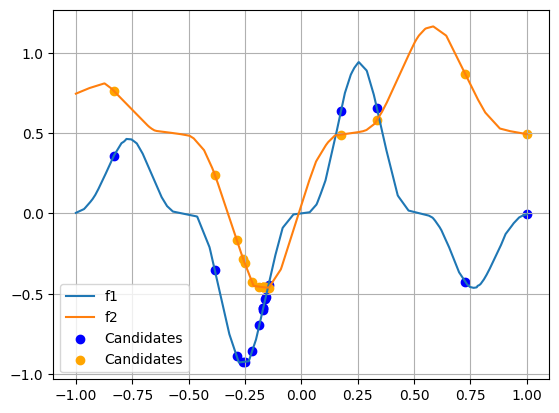

Iteration 14
Candidate: tensor([[-0.2575]])


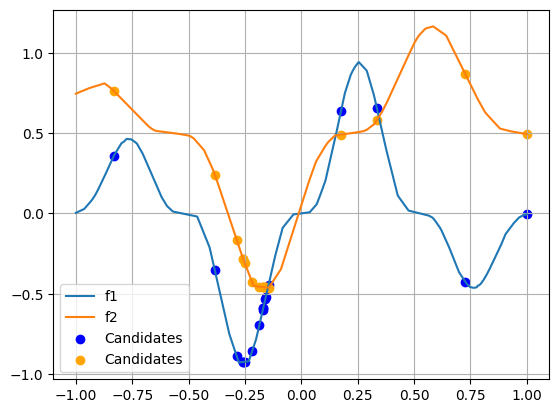

Iteration 15
Candidate: tensor([[-0.1703]])


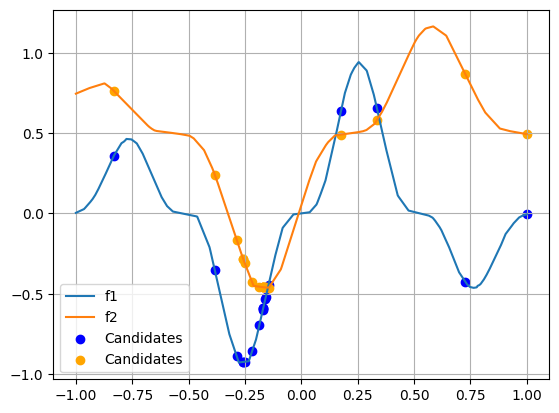

In [ ]:
n_iter = 16# COMPLETE
n_start = 3 # COMPLETE
# generates iterations from 0 to 15.
x, y = generate_initial_data(n_start)# COMPLETE - Call the right function with n_start as the argument to generate initial data
print(x,y)
plot_candidates(torch.cat([x,y], dim=1))

# COMPLETE - Generates candidates and plot for 15 iterations
for i in range(n_iter):
    print(f"Iteration {i}")

    candidates = generate_next_candidate(x,-y) #-y to minimize the optimization process

    print(f"Candidate: {candidates}")

    x = torch.cat([x, candidates])
    y = torch.cat([y,torch.tensor([[f1(i),f2(i)] for i in candidates])])

    plot_candidates(torch.cat([x,y], dim=1))

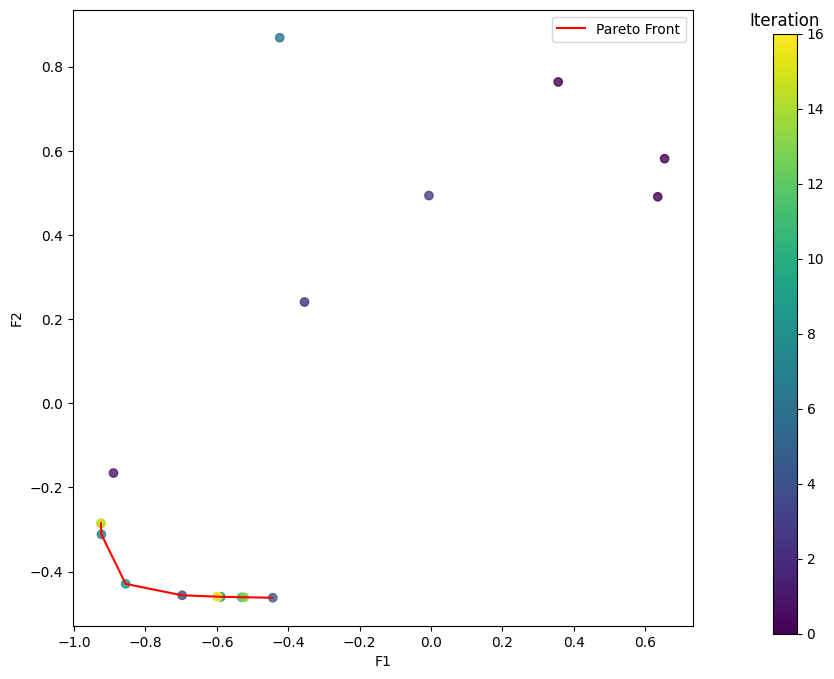

In [ ]:
# Plot the value of objective f1 and objective f2 of all candiates, and mark the pareto front.
# Below is what the figure looks like.
# from botorch.utils.multi_objective.pareto import is_non_dominated can be useful.

# COMPLETE
from matplotlib.cm import ScalarMappable
import numpy as np
from matplotlib import pyplot as plt
from botorch.utils.multi_objective.pareto import is_non_dominated


fig, axes = plt.subplots(1, 1, figsize=(8, 8))

batch_number = torch.cat([torch.zeros(n_start), torch.arange(1, n_iter+1).repeat(1, 1).t().reshape(-1)]).numpy()

sc = axes.scatter(y[:, 0], y[:, 1], c=batch_number, alpha=0.8)

y_sorted = y[y[:, 0].sort()[1]]

axes.plot(
    [_y[0] for non_dominated, _y in zip(is_non_dominated(-y_sorted), y_sorted) if non_dominated],
    [_y[1] for non_dominated, _y in zip(is_non_dominated(-y_sorted), y_sorted) if non_dominated],
    label="Pareto Front",
    c="r"
)


axes.set_xlabel("F1")
axes.set_ylabel("F2")
sm=ScalarMappable(norm=plt.Normalize(batch_number.min(), batch_number.max()))
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1.0, 0.1, 0.03, 0.75])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")

axes.legend()
plt.show()